#### Tech Challenge - Fase 2 - Machine Learning and Time Series

#### O problema 

Desenvolver um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com base em dados históricos do próprio índice

#### O que é o índice Ibovespa 

É o principal indicador de desempenho das ações negociadas na B3 e reúne as empresas mais importantes do mercado de capitais brasileiro. Foi criado em 1968 e, ao longo desses 50 anos, consolidou-se como referência para investidores ao redor do mundo.


https://pt.wikipedia.org/wiki/Ibovespa

https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/ibovespa.htm

#### Fonte de dados 

Dados históricos do índice IBOVESPA disponíveis publicamente no link https://br.investing.com/indices/bovespa-historical-data e importando para o seguinte repositorio do Github https://github.com/RicardViana/fiap-Machine-Learning-and-Time-Series/blob/main/Dados%20Hist%C3%B3ricos%20Ibovespa.csv

#### Dicionário de dados


| Nome da Coluna | Descrição | Tipo de Dado |
| :--- | :--- | :--- |
| `Data` | A data da observação, no formato "DD/MM/AAAA". | Texto (object) |
| `Ultimo` | O preço de fechamento do Ibovespa no dia. | Numérico (float64) |
| `Abertura` | O preço de abertura do Ibovespa no dia. | Numérico (float64) |
| `Maxima` | O preço máximo atingido pelo Ibovespa no dia. | Numérico (float64) |
| `Minima` | O preço mínimo atingido pelo Ibovespa no dia. | Numérico (float64) |
| `Volume` | O volume de negociações do dia. Os valores são representados em texto com sufixos (ex: "B" para bilhões, "M" para milhões). | Texto (object) |
| `Variacao` | A variação percentual do Ibovespa no dia. | Texto (object) |

#### Objetivo

Criar um modelo que preveja se o fechamento do IBOVESPA do dia seguinte será maior ou menor que o do dia atual, ou seja:

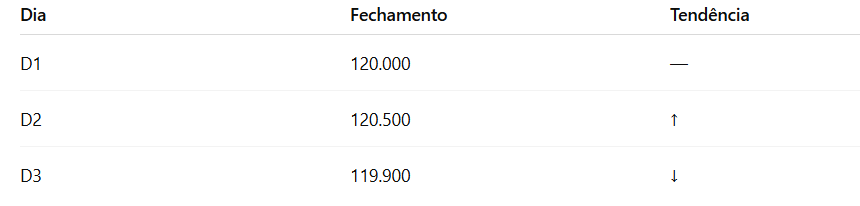

Onde deve prever a tendência (↑ ou ↓) com acuracidade mínima de 75% em um conjunto de teste, esse que contera o último mês (30 dias) de dados disponíveis

#### Desenvolvimento

##### Importação de bibliotecas e pacotes

In [967]:
# Importar biblioteca completa
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import calendar
import pandas_ta as ta

# Importar função especifica de um módulo
from statsmodels.tsa.seasonal import seasonal_decompose # --> Gerar a decomposição dos dados
from sklearn.preprocessing import StandardScaler # --> Normalizar os dados
from datetime import date

# Importar função especifica de um módulo --> Modelos de ML
from sklearn.ensemble import RandomForestClassifier # --> Modelo de ML Random Forest
from sklearn.linear_model import LogisticRegression # --> Modelo de ML Regressão Logistica 
from catboost import CatBoostClassifier # --> Modelo de ML CatBoost
from lightgbm import LGBMClassifier # --> Modelo de ML LightGBM
from xgboost import XGBClassifier # --> Modelo de ML XGBoost
from sklearn.svm import SVC # --> Modelo de ML SVC

# Importar função especifica de um módulo --> Metricas para analisar o modelo  
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Importar função especifica de um módulo --> Melhores hiperparametros 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline

# Outros import
import ipywidgets as widgets
from IPython.display import display

##### Criação de funções (DEF)

In [968]:
# Função para gerar a matriz de confusão e a curva roc

def analisar_modelo_selecionado(nome_modelo, modelos_avaliados, y_test, x_test_scaled):
    
    # Salvar o modelo e a previsão em suas respectivas variaveis
    modelo_selecionado = modelos_avaliados[nome_modelo]["modelo"]
    previsoes_selecionadas = modelos_avaliados[nome_modelo]["previsoes"]

    print(f"Análise Detalhada para o Modelo: {nome_modelo}")
    
    # Gerar o gráfico de Matriz de Confusão
    cm = confusion_matrix(y_test, previsoes_selecionadas)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Previsto Negativo', 'Previsto Positivo'], 
                yticklabels=['Real Negativo', 'Real Positivo'])
    plt.title(f'Matriz de Confusão - {nome_modelo}', fontsize=14)
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Previsto')

    # Gerar o gráfico de Curva ROC e AUC
    # IF por com do modelo SVM pois ele não tem o predict_proba

    if hasattr(modelo_selecionado, "predict_proba"):
        y_pred_proba = modelo_selecionado.predict_proba(x_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

        plt.subplot(1, 2, 2) # Cria um subplot na posição 2
        plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Classificador Aleatório')
        plt.xlabel('Taxa de Falsos Positivos (FPR)')
        plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
        plt.title(f'Curva ROC - {nome_modelo}', fontsize=14)
        plt.legend()
        plt.grid()

    else:
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, 'Curva ROC não disponível\npara este modelo (ex: SVM sem probabilidade).', 
                 ha='center', va='center', fontsize=12)
        plt.title(f'Curva ROC - {nome_modelo}', fontsize=14)
        plt.gca().set_axis_off()

    plt.tight_layout()
    plt.show()

In [969]:
# Função para analisar e plotar a importância das features do modelo selecionado

def analisar_importancia_features(nome_modelo, modelos_avaliados, x_train):
    """
    Esta função extrai e plota a importância das features para um modelo de machine learning.

    Parâmetros:
    - nome_modelo (str): O nome do modelo a ser analisado (ex: "XGBoost").
    - modelos_avaliados (dict): Dicionário contendo os modelos treinados.
    - x_train (pd.DataFrame): DataFrame com as features de treino para obter os nomes das colunas.
    """
    
    # Salva o modelo selecionado em uma variável
    modelo_selecionado = modelos_avaliados[nome_modelo]["modelo"]

    print(f"Análise de Importância das Features para o Modelo: {nome_modelo}")
    
    importances = None
    
    # Verifica se o modelo tem o atributo 'feature_importances_' (comum em árvores de decisão)
    if hasattr(modelo_selecionado, 'feature_importances_'):
        importances = modelo_selecionado.feature_importances_
        
    # Verifica se o modelo tem o atributo 'coef_' (comum em modelos lineares)
    elif hasattr(modelo_selecionado, 'coef_'):
        # Usamos o valor absoluto dos coeficientes como medida de importância
        importances = np.abs(modelo_selecionado.coef_[0])
        
    # Se o modelo não tiver um atributo de importância direta, exibe uma mensagem
    else:
        plt.figure(figsize=(10, 5))
        plt.text(0.5, 0.5, f'A importância das features não está diretamente disponível\\npara o modelo {nome_modelo}.', 
                 ha='center', va='center', fontsize=12, color='red')
        plt.title(f'Importância das Features - {nome_modelo}', fontsize=16)
        plt.gca().set_axis_off()
        plt.show()
        return

    # Cria um DataFrame para facilitar a ordenação e a plotagem
    feature_importance_df = pd.DataFrame({
        'Feature': x_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Gera o gráfico de barras
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis', hue='Feature', legend=False)
    plt.title(f'Importância das Features - {nome_modelo}', fontsize=16)
    plt.xlabel('Pontuação de Importância', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



##### Análise Exploratória de Dados (EDA)

In [970]:
"""

Com sugestão do colega da pós Tiago Turra existe uma biblioteca chamada yfinance (https://pypi.org/project/yfinance/) que possi os mesmo dados do site https://br.investing.com/indices/bovespa-historical-data

"""

# Importando os dados via yfinance apenas para referencia
# progress --> Não gerar um print do progresso
# auto_adjust --> corrigir o histórico de preços
# multi_level_index --> Utilizando para evitar gerar coluna com o nome do ticket, exemplo ('Close', '^BVSP')

dados_yf = yf.download('^BVSP', period="max", interval="1d", auto_adjust=True,  progress=False, multi_level_index=False)

print("Primeiros dados")
display(dados_yf.head())

print("\nUltimos dados")
display(dados_yf.tail())

Primeiros dados


,Close,High,Low,Open,Volume
Date,,,,,
1993-04-27,24.500000,25.400000,24.500000,24.799999,0
1993-04-28,24.299999,24.600000,23.700001,24.500000,0
1993-04-29,23.700001,24.799999,23.700001,24.299999,0
1993-04-30,24.100000,24.200001,23.700001,23.700001,0
1993-05-03,24.100000,24.400000,23.799999,24.100000,0



Ultimos dados


,Close,High,Low,Open,Volume
Date,,,,,
2025-07-23,135368.0,135782.0,133676.0,134036.0,6527600
2025-07-24,133808.0,135363.0,133648.0,135357.0,5976800
2025-07-25,133524.0,134204.0,133285.0,133820.0,5560900
2025-07-28,132129.0,133902.0,131550.0,133538.0,6625600
2025-07-29,132726.0,133346.0,132130.0,132130.0,6324800


In [971]:
# Opção de já transformar o campa data em Data e Index

link = r"https://raw.githubusercontent.com/RicardViana/fiap-Machine-Learning-and-Time-Series/refs/heads/main/Dados%20Hist%C3%B3ricos%20Ibovespa.csv"
dados_origem_teste = pd.read_csv(link, sep= ";", thousands='.', decimal=',', parse_dates=["Data"], dayfirst=True, index_col="Data")
display(dados_origem_teste.head())

,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
Data,,,,,,
1995-01-02,4301,4354,4398,4300,"4,10B","-1,22%"
1995-01-03,4098,4370,4386,4094,"8,35B","-4,72%"
1995-01-04,3968,4098,4098,3861,"11,95B","-3,17%"
1995-01-05,4037,3968,4040,3944,"8,76B","1,74%"
1995-01-06,3827,4037,4106,3813,"12,02B","-5,20%"


In [972]:
# Importar os dados via github 
# Necessario o uso do arumento thousands e decimal para não ter problema com o data frame --> o . na fonte é para separar o milhar

link = r"https://raw.githubusercontent.com/RicardViana/fiap-Machine-Learning-and-Time-Series/refs/heads/main/Dados%20Hist%C3%B3ricos%20Ibovespa.csv"
dados_origem = pd.read_csv(link, sep= ";", thousands='.', decimal=',', index_col="Data")

In [973]:
# Verificando os dados via .head e .tail

print("Primeiros dados (.head)")
display(dados_origem.head())

print("\nUltimos dados (.tail)")
display(dados_origem.tail())

Primeiros dados (.head)


,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
Data,,,,,,
02/01/1995,4301,4354,4398,4300,"4,10B","-1,22%"
03/01/1995,4098,4370,4386,4094,"8,35B","-4,72%"
04/01/1995,3968,4098,4098,3861,"11,95B","-3,17%"
05/01/1995,4037,3968,4040,3944,"8,76B","1,74%"
06/01/1995,3827,4037,4106,3813,"12,02B","-5,20%"



Ultimos dados (.tail)


,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
Data,,,,,,
30/06/2025,138855,136865,139103,136430,"7,68B","1,45%"
01/07/2025,139549,138855,139695,138855,"6,35B","0,50%"
02/07/2025,139051,139586,140049,138384,"8,81B","-0,36%"
03/07/2025,140928,139051,141304,139051,"6,08B","1,35%"
04/07/2025,141264,140928,141564,140597,"3,31B","0,24%"


In [974]:
# Ajustar o formato da coluna Data 

dados_origem.index = pd.to_datetime(dados_origem.index, format = "%d/%m/%Y")

In [975]:
# Verificand os dados os dados do data frame dados_origem com o dados_yf --> Verificar se há diferença 

print("Dados do data frame dados_origem")
display(dados_origem[['Ultimo', 'Abertura', 'Maxima', 'Minima']].tail())

print("\nDados do data frame dados_yf")
display(dados_yf[['Close', 'Open', 'High', 'Low']].query("Date >= '2025-06-30 00:00:00' and Date <= '2025-07-04 00:00:00'"))


Dados do data frame dados_origem


,Ultimo,Abertura,Maxima,Minima
Data,,,,
2025-06-30,138855,136865,139103,136430
2025-07-01,139549,138855,139695,138855
2025-07-02,139051,139586,140049,138384
2025-07-03,140928,139051,141304,139051
2025-07-04,141264,140928,141564,140597



Dados do data frame dados_yf


,Close,Open,High,Low
Date,,,,
2025-06-30,138855.0,136865.0,139103.0,136430.0
2025-07-01,139549.0,138855.0,139695.0,138855.0
2025-07-02,139051.0,139586.0,140049.0,138384.0
2025-07-03,140928.0,139051.0,141304.0,139051.0
2025-07-04,141478.0,140928.0,141537.0,140597.0


In [976]:
# Veficiando os dados dados do data frame 

dados_origem.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7555 entries, 1995-01-02 to 2025-07-04
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Ultimo    7555 non-null   int64 
 1   Abertura  7555 non-null   int64 
 2   Maxima    7555 non-null   int64 
 3   Minima    7555 non-null   int64 
 4   Volume    7554 non-null   object
 5   Variacao  7555 non-null   object
dtypes: int64(4), object(2)
memory usage: 413.2+ KB


In [977]:
# Verificando os dados nulos
dados_origem.isnull().sum()

Ultimo      0
Abertura    0
Maxima      0
Minima      0
Volume      1
Variacao    0
dtype: int64

In [978]:
# Verificando os registros que estão nulos 
# Como para o nosso projeto esse campo Volume não é util, vamos manter esse registro
dados_origem[dados_origem.isnull().any(axis=1)]

,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
Data,,,,,,
2016-02-10,40377,40592,40592,39960,NaN,"-0,53%"


In [979]:
# Gerando a estatistica descritiva do data frame 

dados_origem.describe()

,Ultimo,Abertura,Maxima,Minima
count,7555.000000,7555.000000,7555.000000,7555.000000
mean,53401.158306,53384.248180,53908.211251,52869.344937
std,38204.901048,38195.050622,38475.116909,37923.170704
min,2138.000000,2138.000000,2449.000000,2110.000000
25%,15098.500000,15094.000000,15275.500000,14858.000000
50%,52230.000000,52210.000000,52836.000000,51585.000000
75%,73438.000000,73435.000000,74463.000000,72493.500000
max,141264.000000,140928.000000,141564.000000,140597.000000


In [980]:
# Verificando o intervalo de data dos dados 

print(f"Data inicial é {dados_origem.index.min()}")
print(f"Data final   é {dados_origem.index.max()}")

Data inicial é 1995-01-02 00:00:00
Data final   é 2025-07-04 00:00:00


In [981]:
# Criando um novo data frame apenas com os campos necessarios

dados_ultimo = dados_origem["Ultimo"].copy()
dados_ultimo.tail()

Data
2025-06-30    138855
2025-07-01    139549
2025-07-02    139051
2025-07-03    140928
2025-07-04    141264
Name: Ultimo, dtype: int64

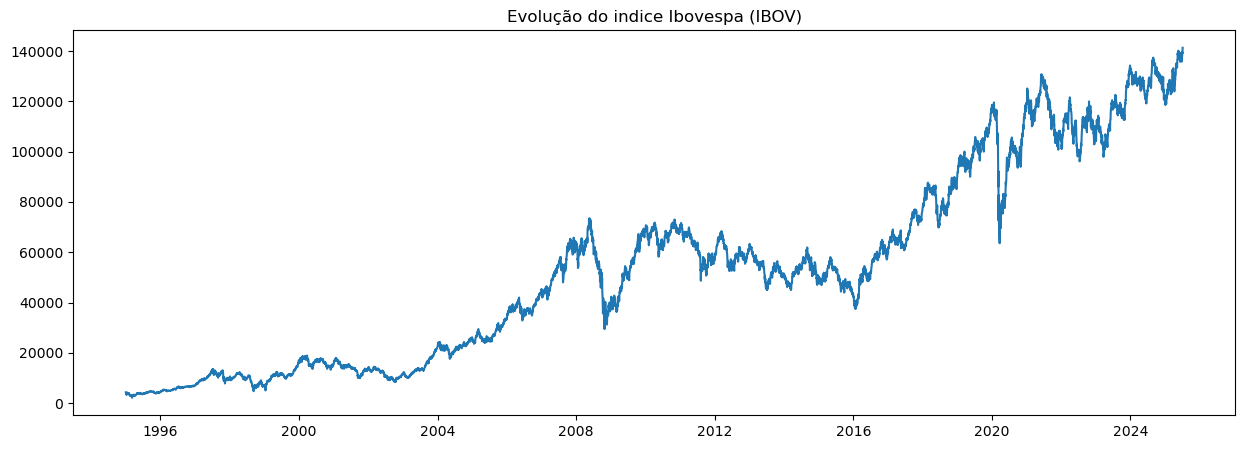

In [982]:
# Plotando um grafico de linha 

plt.figure(figsize=(15,5))
plt.plot(dados_ultimo.index,dados_ultimo)
plt.title("Evolução do indice Ibovespa (IBOV)")
plt.show()

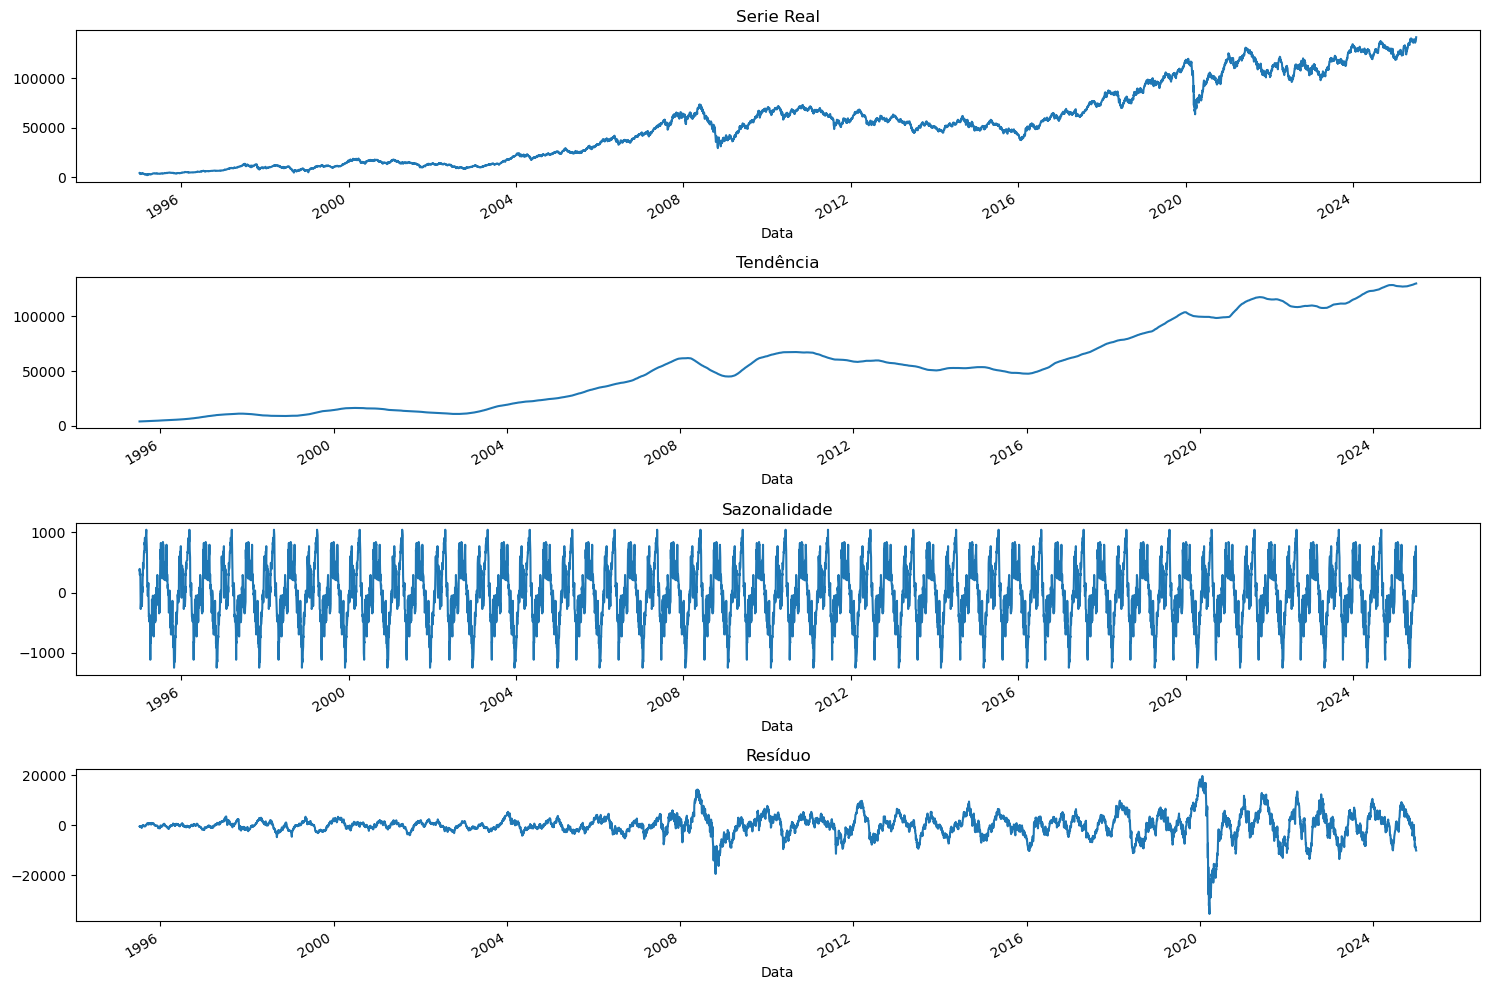

In [983]:
# Realizar a decomposição da seria temporal -->  tendência (trend), sazonalidade (seasonal) e resíduo (resid) e gerar o graficos 

periodo = 252 # Média de dias uteis

resultados = seasonal_decompose(dados_ultimo, period=periodo)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)
ax1.set_title("Serie Real")

resultados.trend.plot(ax=ax2)
ax2.set_title("Tendência")

resultados.seasonal.plot(ax=ax3)
ax3.set_title("Sazonalidade")

resultados.resid.plot(ax=ax4)
ax4.set_title("Resíduo")

plt.tight_layout()
plt.show()

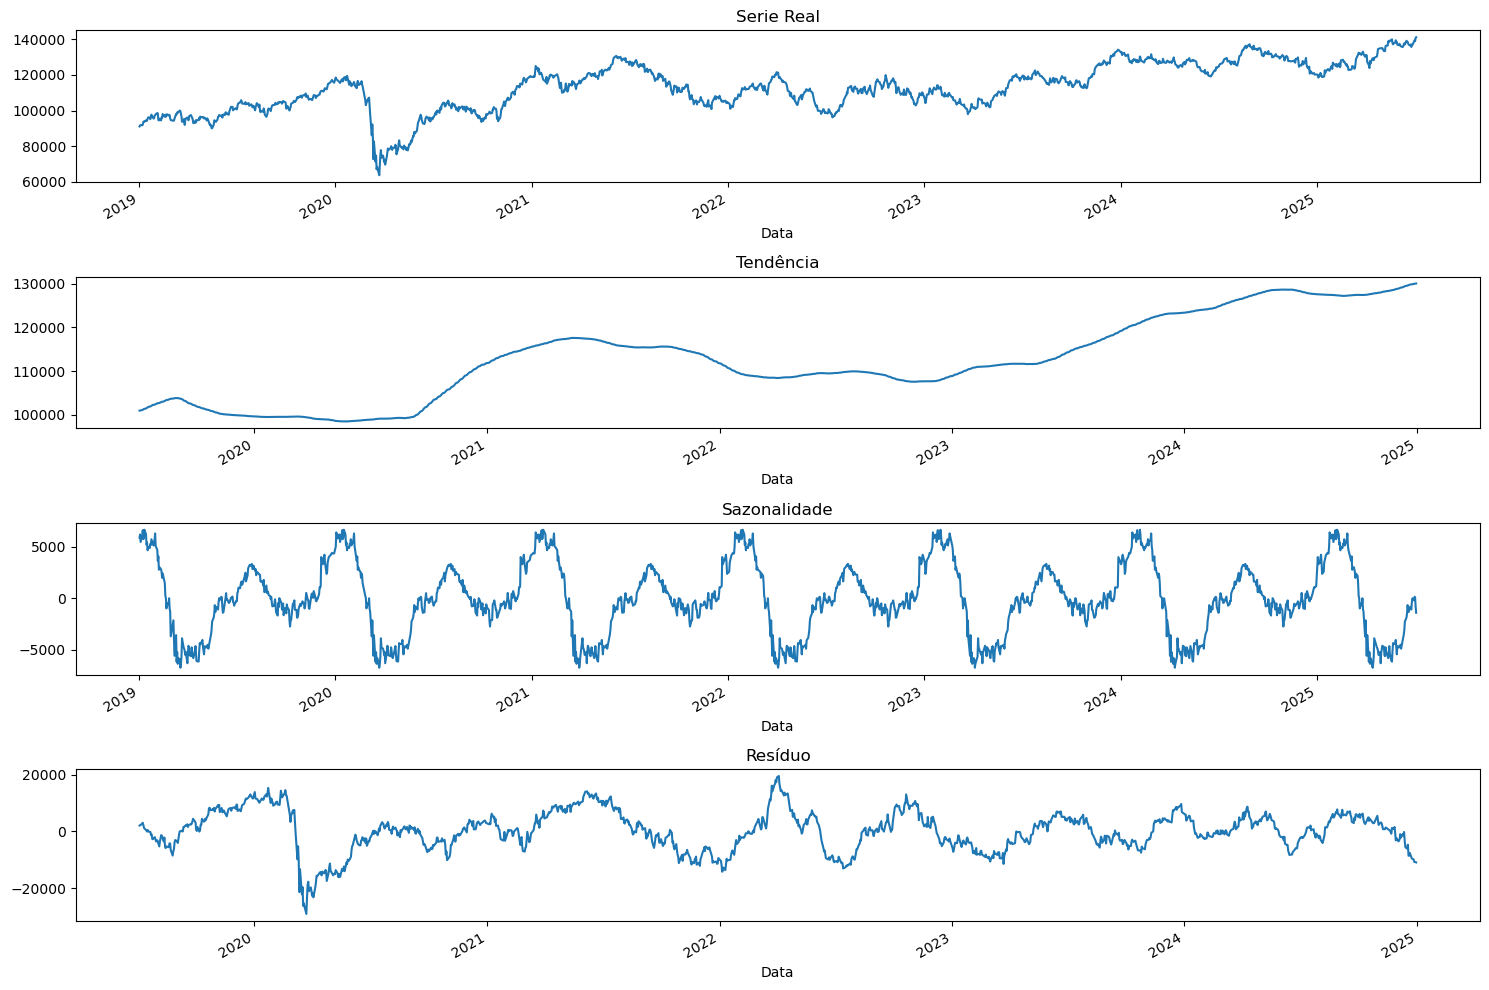

In [984]:
"""

O ano de 2020 houve a pandemia e dessa forma, plotamos novamente o decompose para verificar a partir do ano de 2019 

"""

periodo = 252  # Média de dias úteis

# Filtrar os dados a partir de 2019
dados_ultimo_2019 = dados_ultimo[dados_ultimo.index >= "2019-01-01"]

# Realizar a decomposição
resultados = seasonal_decompose(dados_ultimo_2019, period=periodo)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

resultados.observed.plot(ax=ax1)
ax1.set_title("Serie Real")

resultados.trend.plot(ax=ax2)
ax2.set_title("Tendência")

resultados.seasonal.plot(ax=ax3)
ax3.set_title("Sazonalidade")

resultados.resid.plot(ax=ax4)
ax4.set_title("Resíduo")

plt.tight_layout()
plt.show()

##### Feature Engineering

In [985]:
# Criar um novo data frame com os dados originais

excluir_anos = "Não"
anos_excluir = [2020]

if excluir_anos == "Sim":
    mascara = ~dados_origem.index.year.isin(anos_excluir)
    dados = dados_origem.loc[mascara, ["Ultimo", "Abertura", "Maxima", "Minima"]].copy()

else:
    dados = dados_origem[["Ultimo", "Abertura", "Maxima", "Minima"]].copy()

In [986]:
# Alterando o nome das colunas 

dados.index.name = "data"
dados = dados.rename(columns={"Ultimo":"ultimo", "Abertura":"abertura", "Maxima":"maxima", "Minima":"minima"})

In [987]:
# Ordernando os dados 

dados = dados.sort_index()

In [988]:
# Criar a variavel Target (Alvo) --> 1 para sobe e 0 para desce 
# Avaliamos o valor atual com o valor do proximo dia e dessa forma conseguimos definir se o dia seguinte subiu (1) ou desceu (0)

# Versão sem o limite 
#dados['ultimo_amanha'] = dados["ultimo"].shift(-1) # --> Etapa apenas para enteder os calculos e não é necessarios para o modelo
#dados['ultimo_diferenca'] = dados["ultimo"].shift(-1) - dados["ultimo"] # --> Etapa apenas para enteder os calculos e não é necessarios para o modelo

dados['target'] = (dados["ultimo"].shift(-1) > dados["ultimo"]).astype(int)

# Versão com o limite 
# limitar o percentual
#limite = 0.005  # 0.5%

# Calcula a variação percentual do fechamento do dia seguinte em relação ao dia atual
#delta = (dados["ultimo"].shift(-1) - dados["ultimo"]) / dados["ultimo"]

# Cria a coluna target: 1 para alta acima do limite, 0 para baixa abaixo do limite, np.nan para ruído
#dados["target"] = np.where(delta > limite, 1, np.where(delta < -limite, 0, np.nan))

dados.tail()

,ultimo,abertura,maxima,minima,target
data,,,,,
2025-06-30,138855,136865,139103,136430,1
2025-07-01,139549,138855,139695,138855,0
2025-07-02,139051,139586,140049,138384,1
2025-07-03,140928,139051,141304,139051,1
2025-07-04,141264,140928,141564,140597,0


In [989]:
# Criar as variações percentuais (lags) --> Comparar percentualmente o dia de hoje com n dias anteriores
# Features Defasadas (Lagged Features) --> Os preços e volumes dos dias anteriores são informações muito importantes

qtd_lags = 10

for i in range (1, qtd_lags+1):
    dados[f"lag_{i}"] = dados["ultimo"].pct_change(i)

dados.tail()

,ultimo,abertura,maxima,minima,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
data,,,,,,,,,,,,,,,
2025-06-30,138855,136865,139103,136430,1,0.014532,0.012697,0.022745,0.012321,0.016873,0.012683,0.000995,0.000108,-0.002880,0.011967
2025-07-01,139549,138855,139695,138855,0,0.004998,0.019603,0.017759,0.027857,0.017381,0.021955,0.017744,0.005998,0.005107,0.002104
2025-07-02,139051,139586,140049,138384,1,-0.003569,0.001412,0.015965,0.014127,0.024188,0.013750,0.018308,0.014112,0.002408,0.001520
2025-07-03,140928,139051,141304,139051,1,0.013499,0.009882,0.014929,0.029679,0.027816,0.038014,0.027434,0.032054,0.027801,0.015939
2025-07-04,141264,140928,141564,140597,0,0.002384,0.015915,0.012290,0.017349,0.032134,0.030267,0.040488,0.029884,0.034515,0.030252


In [990]:
# Criar médias moveis

#dias_medias = [5, 22, 66, 132, 252] 
dias_medias = [5, 22, 66] 

criar_media = "Não"

if criar_media == "Sim":
    
    for dias in dias_medias:
        dados[f"MA_{dias}"] = dados["ultimo"].rolling(window=dias).mean().shift(1)

    dados.tail()

In [991]:
# Criar Volatilidade

criar_volatilidade = "Sim"

if criar_volatilidade == "Sim":
    dados["Volatilidade"] = dados["maxima"] - dados["minima"]
    dados["Volatilidade_relativa"] = dados["Volatilidade"] / dados["minima"]

    dados.tail()

In [992]:
# Criar restante dos indicadores tecnicos
# mme --> Média Móvel Exponencial (EMA - Exponential Moving Average): Semelhante à SMA, mas dá mais peso aos preços mais recentes, reagindo mais rápido a mudanças
# rsi --> Índice de Força Relativa (RSI - Relative Strength Index): Mede a velocidade e a mudança dos movimentos de preços, indicando se um ativo está sobrecomprado ou sobrevendido.
# macd --> Convergência e Divergência de Médias Móveis (MACD - Moving Average Convergence Divergence): Usa duas médias móveis exponenciais para gerar sinais de compra e venda
# bbands --> Bandas de Bollinger (Bollinger Bands): Medem a volatilidade do mercado, consistindo em uma média móvel (banda do meio) e duas bandas de desvio padrão (superior e inferior)
# stoch --> Oscilador Estocástico (%K e %D): Compara o preço de fechamento de um ativo com sua faixa de preço durante um determinado período

custom_strategy = ta.Strategy(
    name="Estrategia Mista",
    description="SMA, EMA, RSI, MACD, BBands, e Stochastic",
    ta=[
        {"kind": "ema", "length": 20},
        {"kind": "rsi", "length": 14},
        {"kind": "macd", "fast": 12, "slow": 26, "signal": 9},
        {"kind": "bbands", "length": 20, "std": 2},
        {"kind": "stoch", "k": 14, "d": 3}
    ]
)

incluir_dados = "Não"

if incluir_dados == "Sim":
    dados = dados.rename(columns={"ultimo":"close", "abertura":"open", "maxima":"high", "minima":"low"})
    dados.ta.strategy(custom_strategy)
    dados = dados.rename(columns={"close":"ultimo", "open":"abertura", "high":"maxima", "low":"minima"})
    dados.tail()


In [993]:
# Tratar o data frame para evitar o data leakage --> empurrar os dados para a linha de baixo

colunas_excluir = ["target"]
features_a_deslocar = [col for col in dados.columns if col not in colunas_excluir]

dados[features_a_deslocar] = dados[features_a_deslocar].shift(1)

dados.tail()

,ultimo,abertura,maxima,minima,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,Volatilidade,Volatilidade_relativa
data,,,,,,,,,,,,,,,,,
2025-06-30,136866.0,137113.0,137209.0,136469.0,1,-0.001809,0.008095,-0.002180,0.002307,-0.001823,-0.013344,-0.014218,-0.017163,-0.002529,-0.006778,740.0,0.005422
2025-07-01,138855.0,136865.0,139103.0,136430.0,0,0.014532,0.012697,0.022745,0.012321,0.016873,0.012683,0.000995,0.000108,-0.002880,0.011967,2673.0,0.019592
2025-07-02,139549.0,138855.0,139695.0,138855.0,1,0.004998,0.019603,0.017759,0.027857,0.017381,0.021955,0.017744,0.005998,0.005107,0.002104,840.0,0.006049
2025-07-03,139051.0,139586.0,140049.0,138384.0,1,-0.003569,0.001412,0.015965,0.014127,0.024188,0.013750,0.018308,0.014112,0.002408,0.001520,1665.0,0.012032
2025-07-04,140928.0,139051.0,141304.0,139051.0,0,0.013499,0.009882,0.014929,0.029679,0.027816,0.038014,0.027434,0.032054,0.027801,0.015939,2253.0,0.016203


In [994]:
# Excluir do data frame os registros vazios

dados = dados.dropna()
dados.head()

,ultimo,abertura,maxima,minima,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,Volatilidade,Volatilidade_relativa
data,,,,,,,,,,,,,,,,,
1995-01-17,4056.0,4104.0,4104.0,3865.0,0,-0.011696,0.055975,0.159188,0.240367,0.117971,0.059838,0.004706,0.022177,-0.010249,-0.056963,239.0,0.061837
1995-01-18,4210.0,4056.0,4256.0,3985.0,0,0.037968,0.025828,0.096069,0.203201,0.287462,0.160419,0.100078,0.042854,0.060988,0.027330,271.0,0.068005
1995-01-19,4078.0,4210.0,4221.0,4078.0,1,-0.031354,0.005424,-0.006335,0.061703,0.165476,0.247095,0.124035,0.065587,0.010156,0.027722,143.0,0.035066
1995-01-20,3809.0,4078.0,4078.0,3776.0,0,-0.065964,-0.095249,-0.060897,-0.071881,-0.008331,0.088597,0.164832,0.049890,-0.004703,-0.056478,302.0,0.079979
1995-01-23,3862.0,3809.0,3871.0,3635.0,1,0.013914,-0.052967,-0.082660,-0.047830,-0.058967,0.005467,0.103744,0.181040,0.064498,0.009146,236.0,0.064924


##### Separar a base entre treino e teste

In [995]:
# Gerar datas para filtrar treino e teste 

# Definir o ano e mês do intervalo + anos 
ano = 2025
mes = 6
anos = 10

# Gerar as variaveis 
data_inicio_teste = pd.to_datetime(date(ano, mes, 1))
ultimo_dia = calendar.monthrange(ano, mes)[1]
data_fim_teste = pd.to_datetime(date(ano, mes, ultimo_dia))

ano_atual = date.today().year
ano_inicio_treino = ano_atual - anos
data_inicio_treino = pd.to_datetime(date(ano_inicio_treino,1,1))

In [996]:
# Separar os dados para treino e teste 

# Melhor acuracidade
lista = ["ultimo","abertura", "maxima", "minima","target"]

# Testes
#lista = ["abertura", "maxima", "minima","target"]
#lista = ["target"]
#lista = ["ultimo","abertura", "maxima", "minima","target"]
#lista = ["maxima", "minima","target"]
#lista = ["ultimo","maxima", "minima","target"]

x = dados.drop(columns=lista)
y = dados["target"].copy()

print("Features (x):")
display(x.tail())

print("\nAlvo (y):")
display(y.tail())

Features (x):


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,Volatilidade,Volatilidade_relativa
data,,,,,,,,,,,,
2025-06-30,-0.001809,0.008095,-0.002180,0.002307,-0.001823,-0.013344,-0.014218,-0.017163,-0.002529,-0.006778,740.0,0.005422
2025-07-01,0.014532,0.012697,0.022745,0.012321,0.016873,0.012683,0.000995,0.000108,-0.002880,0.011967,2673.0,0.019592
2025-07-02,0.004998,0.019603,0.017759,0.027857,0.017381,0.021955,0.017744,0.005998,0.005107,0.002104,840.0,0.006049
2025-07-03,-0.003569,0.001412,0.015965,0.014127,0.024188,0.013750,0.018308,0.014112,0.002408,0.001520,1665.0,0.012032
2025-07-04,0.013499,0.009882,0.014929,0.029679,0.027816,0.038014,0.027434,0.032054,0.027801,0.015939,2253.0,0.016203



Alvo (y):


data
2025-06-30    1
2025-07-01    0
2025-07-02    1
2025-07-03    1
2025-07-04    0
Name: target, dtype: int32

In [997]:
# Separar a base em treino e teste

x_train = x[(x.index >= data_inicio_treino) & (x.index < data_inicio_teste)]
y_train = y[(y.index >= data_inicio_treino) & (y.index < data_inicio_teste)]

x_test = x[(x.index >= data_inicio_teste) & (x.index <= data_fim_teste)]
y_test = y[(y.index >= data_inicio_teste) & (y.index <= data_fim_teste)]

##### Criação dos modelos de Machine Learning

In [998]:
# Preparar o TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [999]:
# Normalizar os dados

scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [1000]:
# Treinar o modelo e gerar a previsao - Regressao Logistica

usar_grid = "Não"

if usar_grid == "Sim":

    pipe_lr = Pipeline(
        [('scaler', StandardScaler()), ('clf', LogisticRegression(solver='liblinear'))]
    )

    param_grid_lr = {
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],  # regularização
        'clf__penalty': ['l1', 'l2'],  # tipo de penalização
        'clf__solver': ['liblinear'],  # necessário para suportar l1
    }

    modelo_rl = GridSearchCV(pipe_lr, param_grid_lr, cv=tscv)
    modelo_rl.fit(x_train, y_train)
    modelo_rl = modelo_rl.predict(x_test)

else: 
    modelo_rl = LogisticRegression(random_state=42)
    modelo_rl.fit(x_train_scaled,y_train)
    previsao_rl = modelo_rl.predict(x_test_scaled)

In [1001]:
# Treinar o modelo e gerar a previsao - Random Forest 

modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(x_train_scaled, y_train)
previsao_rf = modelo_rf.predict(x_test_scaled)

In [1002]:
# Treinar o modelo e gerar a previsao - XGBoost

usar_grid = "Não"

if usar_grid == "Sim":

    pipe_xgb = Pipeline(
        [
            ('scaler', StandardScaler()),
            ('clf', XGBClassifier()),
        ]
    )

    param_grid_xgb = {
        'clf__n_estimators': [50, 100, 200],  # número de árvores
        'clf__max_depth': [3, 5, 7],  # profundidade da árvore
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.3],  # taxa de aprendizado
        'clf__subsample': [0.6, 0.8, 1.0],  # fração das amostras usadas em cada árvore
        'clf__colsample_bytree': [0.6, 0.8, 1.0],  # fração de colunas usadas por árvore
        'clf__gamma': [0, 0.1, 0.5, 1.0],  # regularização mínima para divisão
        'clf__reg_alpha': [0, 0.1, 1],  # L1 regularization
        'clf__reg_lambda': [0.1, 1, 10],  # L2 regularization
    }

    modelo_xgb = RandomizedSearchCV(pipe_xgb, param_grid_xgb, cv=tscv)
    modelo_xgb.fit(x_train, y_train)
    previsao_xgb = modelo_xgb.predict(x_test)

else:
    modelo_xgb = XGBClassifier(random_state=42)
    modelo_xgb.fit(x_train_scaled, y_train)
    previsao_xgb = modelo_xgb.predict(x_test_scaled)

In [1003]:
# Treinar o modelo e gerar a previsao - LightGBM

modelo_lgbm = LGBMClassifier(random_state=42, verbose = -1)
modelo_lgbm.fit(x_train_scaled, y_train)

#previsao_lgbm = modelo_lgbm.predict(x_test_scaled)
previsao_lgbm = modelo_lgbm.predict(pd.DataFrame(x_test_scaled, columns=x_train.columns)) # --> Gerado o predict dessa forma para não gerar o Warning

In [1004]:
# Treinar o modelo e gerar a previsao - CatBoost

modelo_cat = CatBoostClassifier(random_state=42, verbose=0)
modelo_cat.fit(x_train_scaled, y_train)
previsao_cat = modelo_cat.predict(x_test_scaled)

In [1005]:
# Gerar tabela com o score

# # Criar um dicionario com os resultados centralizado que guarda o nome, o objeto do modelo e suas previsões
modelos_avaliados = {
    "Regressão Logística": {"modelo": modelo_rl, "previsoes": previsao_rl},
    "Random Forest":       {"modelo": modelo_rf, "previsoes": previsao_rf},
    "XGBoost":             {"modelo": modelo_xgb, "previsoes": previsao_xgb},
    "LightGBM":            {"modelo": modelo_lgbm, "previsoes": previsao_lgbm},
    "CatBoost":            {"modelo": modelo_cat, "previsoes": previsao_cat}
}

# Criar um data frame com os resultados
performance = pd.DataFrame(
    columns=["Modelo", "Acurácia", "Precisão", "Recall", "F1-Score"]
)

for nome, dados in modelos_avaliados.items():
    report = classification_report(y_test, dados["previsoes"], output_dict=True, zero_division=0)
    
    performance.loc[performance.shape[0]] = {
        "Modelo": nome,
        "Acurácia": report["accuracy"],
        "Precisão": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
    }

performance.set_index("Modelo", inplace=True)
performance_formatada = performance.sort_values(by="Acurácia", ascending=False)
performance_formatada = performance_formatada.map(lambda x: f"{(100 * x):.2f} %")

display(performance_formatada)

,Acurácia,Precisão,Recall,F1-Score
Modelo,,,,
LightGBM,75.00 %,75.00 %,75.00 %,74.81 %
CatBoost,75.00 %,76.79 %,75.00 %,74.00 %
Random Forest,65.00 %,68.12 %,65.00 %,61.51 %
XGBoost,55.00 %,53.93 %,55.00 %,53.20 %
Regressão Logística,45.00 %,20.25 %,45.00 %,27.93 %


##### Verificar importancia das Features

In [1006]:
# Verificar a importancia da feature para cada 

# Selecionar como default o modelo com a melhor acurácia (mesma lógica que você já usou)
modelo_default_features = performance.sort_values(by="Acurácia", ascending=False).index[0]

# Criar o menu suspenso para a importância das features
dropdown_features = widgets.Dropdown(
    options=list(modelos_avaliados.keys()),
    value=modelo_default_features,
    description='Modelo:',
    disabled=False
)

# Cria a interface interativa que chama a função ao mudar o valor do dropdown
widgets.interactive(
    lambda nome_modelo: analisar_importancia_features(nome_modelo, modelos_avaliados, x_train),
    nome_modelo=dropdown_features
)

interactive(children=(Dropdown(description='Modelo:', index=3, options=('Regressão Logística', 'Random Forest'…

##### Analisando o resultado dos modelos de Machine Learning através da Matriz de Confusão e Curva ROC



In [ ]:
# Incluir explicacao dos dois graficos

# Gerar a matriz de confusão e Curva ROC 

# Selecionar como default o modelo com a melhor acurácia
modelo_default = performance.sort_values(by="Acurácia", ascending=False).index[0]

# Criar o menu suspenso 
dropdown = widgets.Dropdown(
    options=list(modelos_avaliados.keys()),
    value=modelo_default,
    description='Modelo: ',
    disabled=False
)

widgets.interactive(
    lambda nome_modelo: analisar_modelo_selecionado(nome_modelo, modelos_avaliados, y_test, x_test_scaled),
    nome_modelo=dropdown
)

interactive(children=(Dropdown(description='Modelo: ', index=3, options=('Regressão Logística', 'Random Forest…